# Introduction

This analysis aims to provide personalized movie recommendations to users on a streaming platform based on their movie preferences and rating history. In the highly competitive streaming industry, offering relevant and tailored content is essential to increasing user engagement and reducing churn. By leveraging the MovieLens dataset from the GroupLens research lab at the University of Minnesota, this project seeks to create a recommendation system that enhances the user experience and drives long-term engagement.

## Business Problem

A streaming service is looking to improve user satisfaction and engagement by offering personalized movie recommendations. Despite having a large library of content, many users are not engaging with the platform as expected, resulting in lower average watch times and higher churn rates. The company wants to develop a movie recommendation system that can provide users with a tailored list of movies based on their past ratings and viewing history, increasing the likelihood of engagement and retention.

### Objectives

**Main Objective:** Build a recommendation system that provides the top 5 movie recommendations to each user based on their ratings of other movies. The model will be built using collaborative filtering techniques and enhanced by a hybrid approach to mitigate the cold-start problem for new users.

**Increase User Engagement**: Offer personalized recommendations that match individual preferences, encouraging users to explore more content on the platform, leading to increased average watch time.

**Improve Retention**: By consistently offering relevant recommendations, the system will help reduce user churn and foster long-term platform loyalty.

**Personalize Content Discovery**: Enable users to discover content that aligns with their unique tastes, ensuring they feel more connected to the platform and its offerings.

**Cold-Start Problem Mitigation**: For new users who haven’t rated or interacted with many movies, implement a hybrid recommendation approach that combines collaborative filtering with content-based filtering to make relevant suggestions early in their platform experience

### Data Understanding


The MovieLens Dataset, sourced from the GroupsLens research Lab at the University of Minnesota contains a colection of movie ratings and associated metadata. For this project we'll use the smaller dataset which contains 100,000 ratings and 3,600 tag applications applied to 9,000 movies by 600 users. THe data files with their features include:

1. **Links.csv** : contains movies unique identifiers. That is their movies ids, tmdbid, imdbid

2. **Movies.csv** : contains the following columns:
3. **Ratings.csv** : contains ratings for movies made by users.The dataset contains the following columns:
4. **Tags.csv** : Each line of this file after the header row represents one tag applied to one movie by one user.

### Data Cleaning and Preperation

The activities conducted include:

1. Handling missing values.
2. Removing duplicate values.
3. Feature engineering.

In [2]:
# import necessary libraries

import pandas as pd
import matplotlib.pyplot as plt
import multiprocessing
import seaborn as sns
import numpy as np
from surprise import Dataset, Reader, SVD, KNNBasic,NMF,KNNWithMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from surprise.model_selection import train_test_split, cross_validate, GridSearchCV
from surprise import Reader, Dataset
from surprise.prediction_algorithms import KNNWithMeans, KNNBasic, KNNBaseline, SVD, NMF
from surprise import accuracy

In [3]:
# read data
link = pd.read_csv('data/links.csv')
link

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0
...,...,...,...
9737,193581,5476944,432131.0
9738,193583,5914996,445030.0
9739,193585,6397426,479308.0
9740,193587,8391976,483455.0


In [4]:
link.isna().sum()

movieId    0
imdbId     0
tmdbId     8
dtype: int64

There are no missing values 

In [5]:
movies = pd.read_csv('data/movies.csv')
movies

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


In [6]:
movies.isna().sum()

movieId    0
title      0
genres     0
dtype: int64

In [7]:
ratings = pd.read_csv('data/ratings.csv')
ratings

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


In [8]:
ratings.isna().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [9]:
tags = pd.read_csv('data/tags.csv')
tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [10]:
tags.isna().sum()

userId       0
movieId      0
tag          0
timestamp    0
dtype: int64

In [11]:
tags

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200
...,...,...,...,...
3678,606,7382,for katie,1171234019
3679,606,7936,austere,1173392334
3680,610,3265,gun fu,1493843984
3681,610,3265,heroic bloodshed,1493843978


In [12]:
# Combine the datasets
movie_ratings = pd.merge(ratings, movies, on='movieId', how='left')
movie_ratings

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,964982224,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
...,...,...,...,...,...,...
100831,610,166534,4.0,1493848402,Split (2017),Drama|Horror|Thriller
100832,610,168248,5.0,1493850091,John Wick: Chapter Two (2017),Action|Crime|Thriller
100833,610,168250,5.0,1494273047,Get Out (2017),Horror
100834,610,168252,5.0,1493846352,Logan (2017),Action|Sci-Fi


In [13]:
movie_ratings.isna().sum()

userId       0
movieId      0
rating       0
timestamp    0
title        0
genres       0
dtype: int64

In [14]:
merged_df = pd.merge(movie_ratings, tags, on='movieId', how='inner')
merged_df

,userId_x,movieId,rating,timestamp_x,title,genres,userId_y,tag,timestamp_y
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,336,pixar,1139045764
1,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,474,pixar,1137206825
2,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,567,fun,1525286013
3,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance,289,moldy,1143424860
4,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance,289,old,1143424860
...,...,...,...,...,...,...,...,...,...
233208,610,168252,5.0,1493846352,Logan (2017),Action|Sci-Fi,567,dark,1525283942
233209,610,168252,5.0,1493846352,Logan (2017),Action|Sci-Fi,567,emotional,1525283946
233210,610,168252,5.0,1493846352,Logan (2017),Action|Sci-Fi,567,gritty,1525283940
233211,610,168252,5.0,1493846352,Logan (2017),Action|Sci-Fi,567,heartbreaking,1525283948


In [15]:
merged_df.isna().sum()

userId_x       0
movieId        0
rating         0
timestamp_x    0
title          0
genres         0
userId_y       0
tag            0
timestamp_y    0
dtype: int64

There are no missing values in the entire dataset 

In [16]:
# drop userId_y and timestamp_y 
merged_df = merged_df.drop(columns=['timestamp_y', 'userId_y', 'timestamp_x'])


In [17]:
# rename userId_x
merged_df = merged_df.rename(columns={'userId_x' : 'userId'})

In [18]:
merged_df.isna().sum()

userId     0
movieId    0
rating     0
title      0
genres     0
tag        0
dtype: int64

In [19]:
merged_df.head()

,userId,movieId,rating,title,genres,tag
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,pixar
1,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,pixar
2,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,fun
3,1,3,4.0,Grumpier Old Men (1995),Comedy|Romance,moldy
4,1,3,4.0,Grumpier Old Men (1995),Comedy|Romance,old


In [20]:
#checking duplicates 
merged_df.duplicated().value_counts()

False    219406
True      13807
Name: count, dtype: int64

We can see that there are `13,807` duplicated rows, hence we drop them 

In [21]:
# dropping duplicates
merged_df = merged_df.drop_duplicates()

# confrming if there are still any duplicates 
merged_df.duplicated().value_counts()

False    219406
Name: count, dtype: int64

## EDA
1. Univariate Analysis
2. Bivariate Analysis

### 1. Univariate Analysis

#### 1.1 Rating

In [23]:
# RATING
merged_df.rating.value_counts()

4.0    60933
5.0    59645
4.5    29403
3.0    27246
3.5    21600
2.0     7567
2.5     6157
1.0     3553
0.5     1822
1.5     1480
Name: rating, dtype: int64

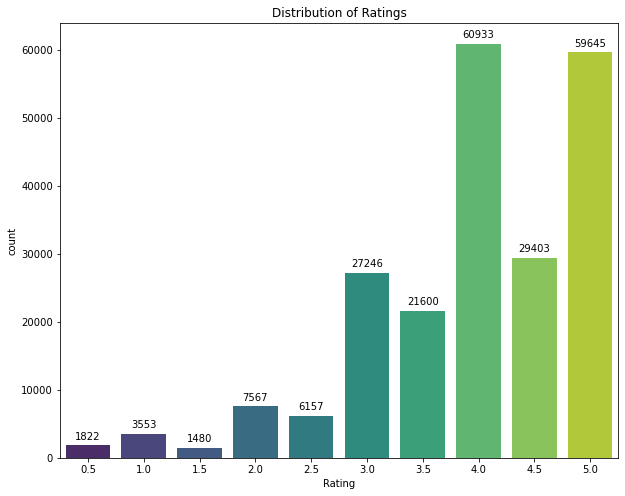

In [24]:
# bar chart 
fig, ax = plt.subplots(figsize=(10,8))

#x
x = merged_df.rating.value_counts().index
#y
y = merged_df.rating.value_counts().values


sns.barplot(x=x,y=y, ax=ax, palette='viridis')
ax.set_xlabel('Rating')
ax.set_ylabel('count')
ax.set_title('Distribution of Ratings');

# Add values on top of each bar
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 9), textcoords='offset points')

- **4.0**(64781) and **5.0**(63845) are the most frequent ratings

#### 1.2 Tags

In [22]:
merged_df['tag'].value_counts()

tag
sci-fi                        1891
atmospheric                   1888
twist ending                  1821
thought-provoking             1743
suspense                      1588
                              ... 
representation of children       1
Titanic                          1
Ninotchka remake                 1
Tokyo                            1
big wave                         1
Name: count, Length: 1584, dtype: int64

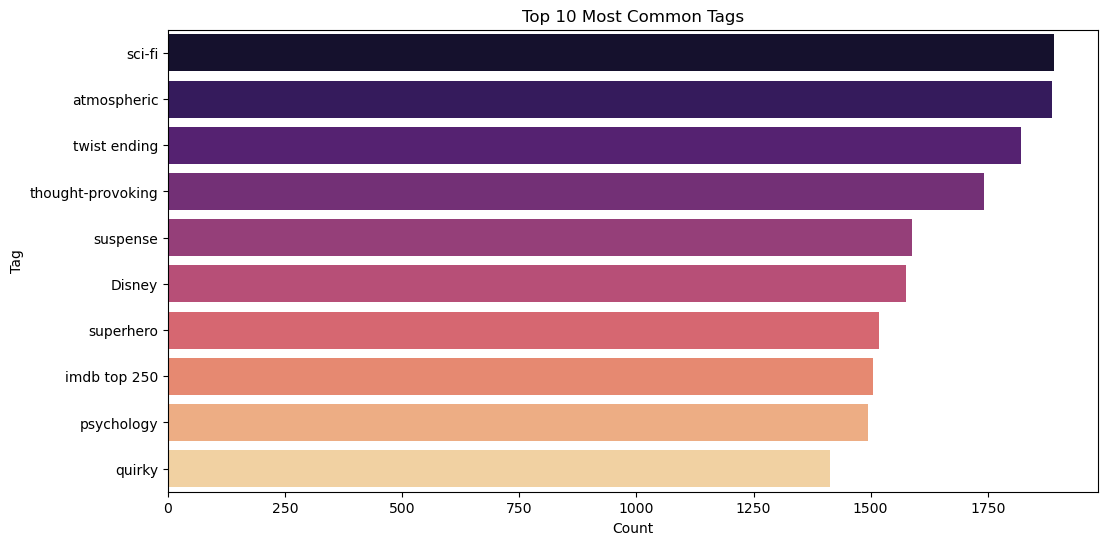

In [23]:
# Number of occurrences for each tag
tag_counts = merged_df['tag'].value_counts()

# Plot the top 10 most common tags
top_10_tags = tag_counts.head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_10_tags.values, y=top_10_tags.index, palette='magma')
plt.title("Top 10 Most Common Tags")
plt.xlabel("Count")
plt.ylabel("Tag")
plt.show()


- **Sci-fi**, **thought-provoking** and **twist ending** are the most common movie tags

#### 1.3 Genres

In [24]:
merged_df['genres'].value_counts()

genres
Comedy|Crime|Drama|Thriller                   54395
Action|Crime|Drama|Thriller                   15018
Action|Adventure|Sci-Fi                        9785
Drama                                          6159
Comedy                                         5212
                                              ...  
Drama|Thriller|Western                            1
Adventure|Comedy|Crime|Drama|Romance              1
Comedy|Crime|Drama|Musical|Mystery|Romance        1
Comedy|Crime|Drama|Mystery|Romance                1
Animation|Drama|Romance|Sci-Fi                    1
Name: count, Length: 370, dtype: int64

In [25]:
# Split genres and explode them into individual rows
merged_df['genres'] = merged_df['genres'].str.split('|')
genre_expl = merged_df.explode('genres')

# Count the occurrences of each genre
genre_counts = genre_expl['genres'].value_counts().head(10)

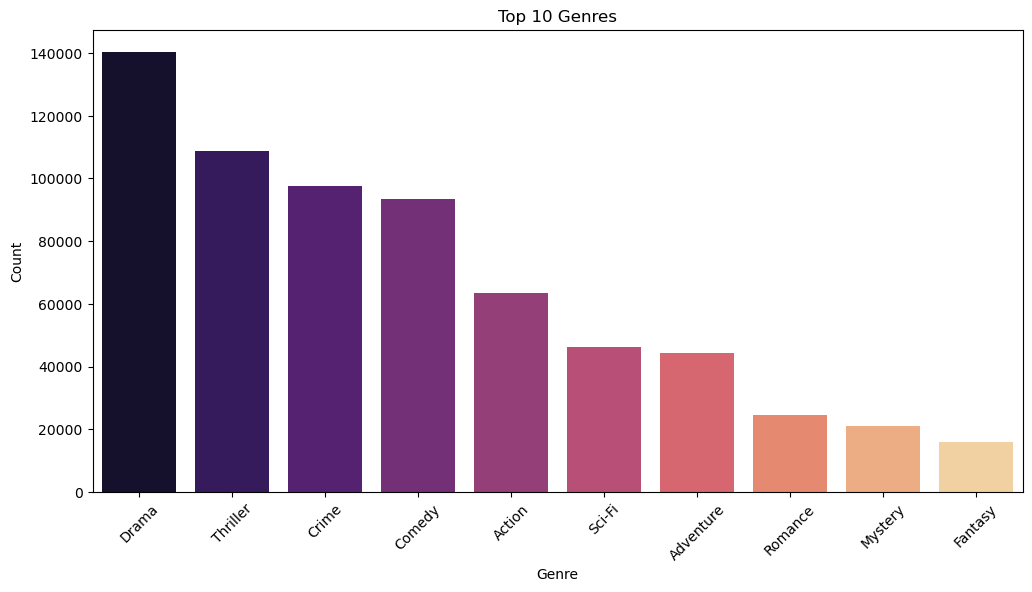

In [26]:
# Plot the top 10 genres
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=genre_counts.index, y=genre_counts.values, palette='magma')
plt.title("Top 10 Genres")
plt.xlabel("Genre")
plt.ylabel("Count")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

- **Drama**(148389) is the top genre.

### 2. Bivariate Analysis

#### 2.1 User id vs Rating

In [27]:
user_ratings = merged_df[['userId', 'title','rating']].drop_duplicates()

Text(0, 0.5, 'Ratings')

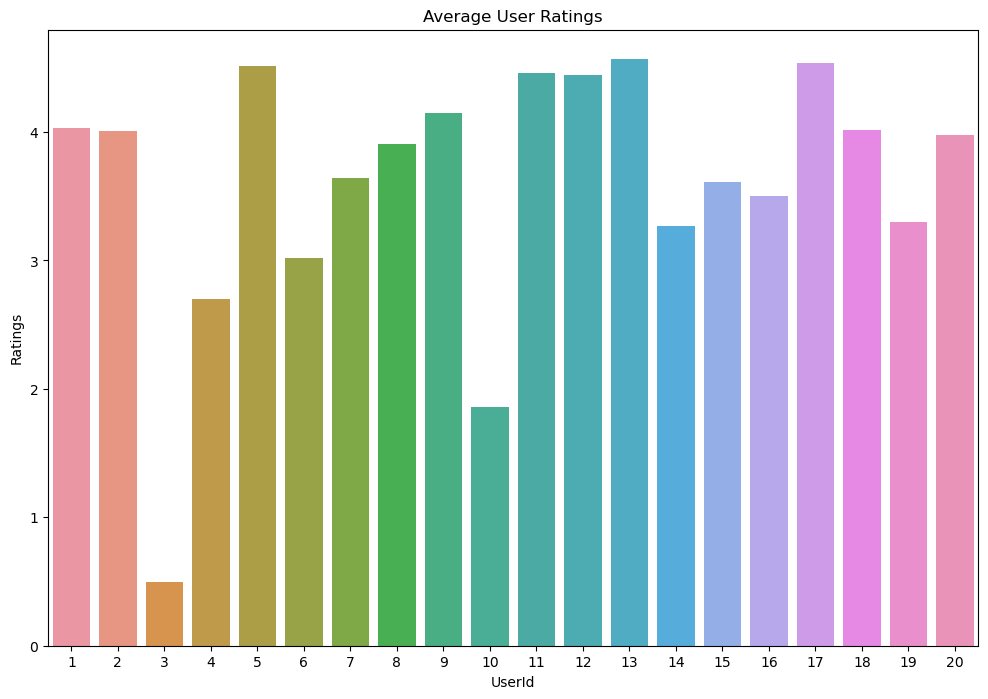

In [28]:
user_ratings = merged_df.groupby('userId').agg({
    'rating':'mean'
}).reset_index()


# plot top 20 user ratings
fig, ax = plt.subplots(figsize=(12,8))
sns.barplot(x= 'userId', y='rating', data = user_ratings[:20])
plt.title('Average User Ratings')
plt.xlabel('UserId')
plt.ylabel('Ratings')

 #### 2.2 Number of ratings per user

c:\Users\ericm\anaconda3\envs\learn-env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


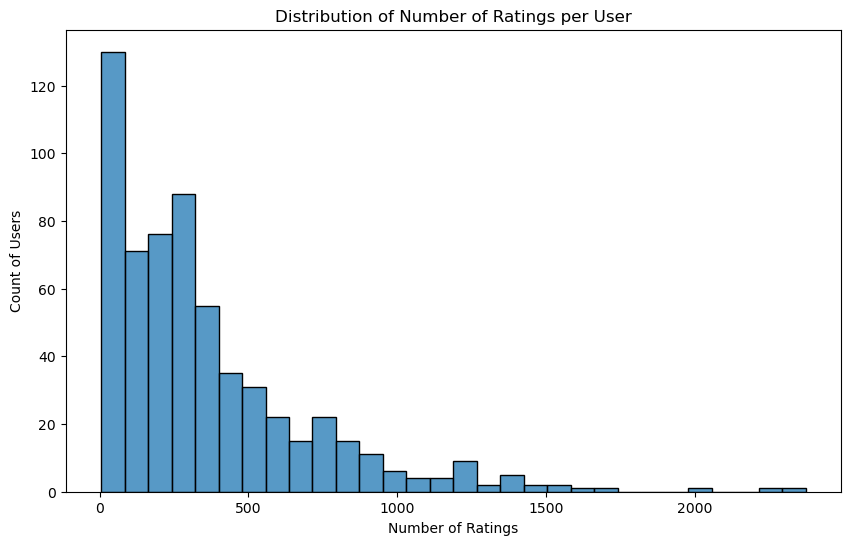

In [29]:
# Number of ratings per user
ratings_per_user = merged_df.groupby('userId')['rating'].count().sort_values(ascending=False)

# Plot the distribution of ratings per user
plt.figure(figsize=(10, 6))
sns.histplot(ratings_per_user, kde=False, bins=30)
plt.title("Distribution of Number of Ratings per User")
plt.xlabel("Number of Ratings")
plt.ylabel("Count of Users")
plt.show();

#### 2.3 Number of ratings per movie

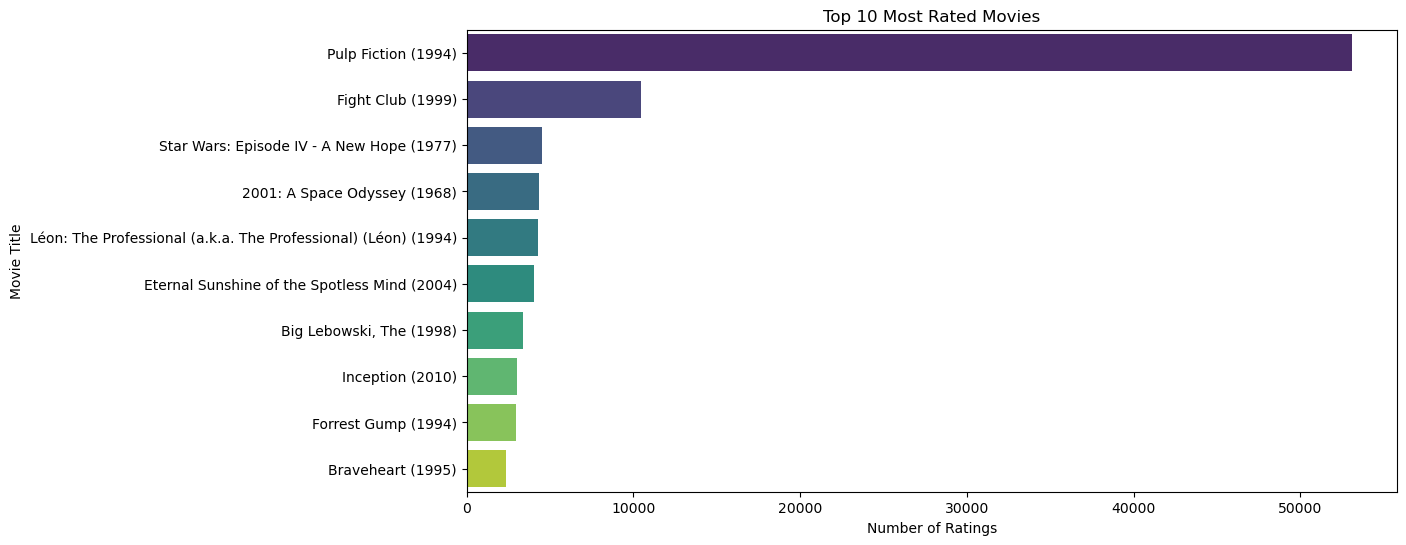

In [30]:
# Number of ratings per movie
ratings_per_movie = merged_df.groupby('title')['rating'].count().sort_values(ascending=False)

# Plot the top 10 most rated movies
top_10_movies = ratings_per_movie.head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_10_movies.values, y=top_10_movies.index, palette='viridis')
plt.title("Top 10 Most Rated Movies")
plt.xlabel("Number of Ratings")
plt.ylabel("Movie Title")
plt.show()


- **PulpFiction** is the most rated movie.

#### 2.4 Highest rated Movies

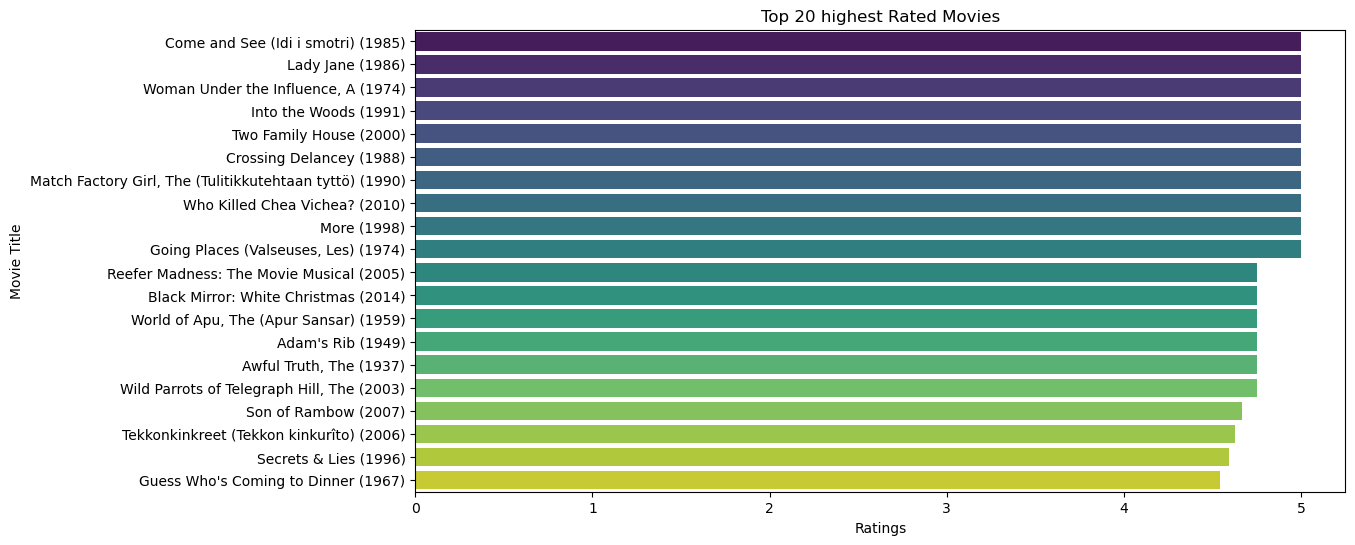

In [31]:
top_rated_movies = merged_df.groupby('title')['rating'].mean().sort_values(ascending=False)
top_rated_movies[:20]

# Plot the top 10 most rated movies
top_20_rated_movies = top_rated_movies[:20]

plt.figure(figsize=(12, 6))
sns.barplot(x=top_20_rated_movies.values, y=top_20_rated_movies.index, palette='viridis')
plt.title("Top 20 highest Rated Movies")
plt.xlabel("Ratings")
plt.ylabel("Movie Title")
plt.show()

#### 2.5 Ratings by Genre

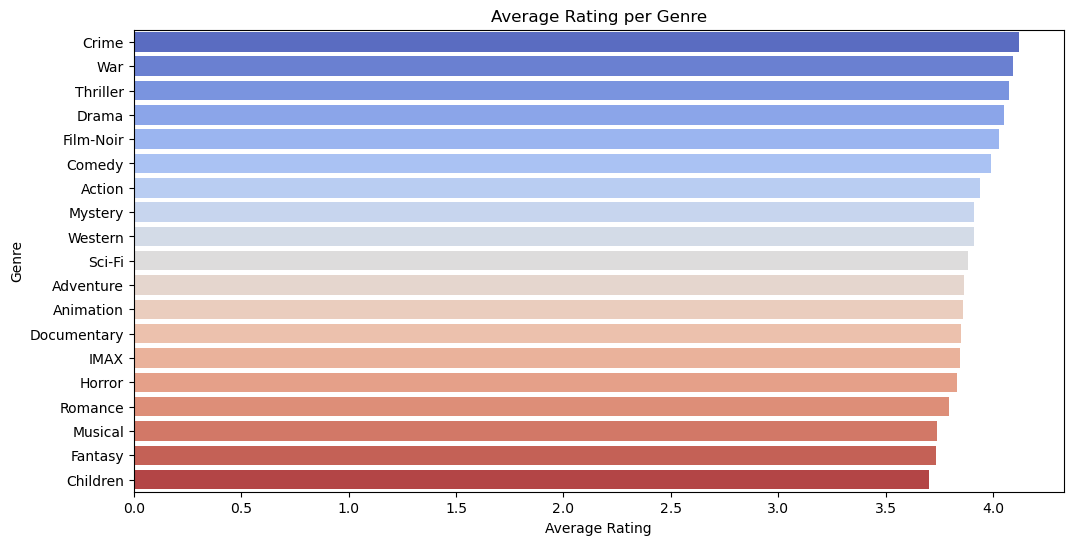

In [32]:
# Split genres and explode them into individual rows
genres_exploded = merged_df.explode('genres')

# Average rating per genre
avg_rating_per_genre = genres_exploded.groupby('genres')['rating'].mean().sort_values(ascending=False)

# Plot the average rating per genre
plt.figure(figsize=(12, 6))
sns.barplot(x=avg_rating_per_genre.values[1:], y=avg_rating_per_genre.index[1:], palette='coolwarm')
plt.title("Average Rating per Genre")
plt.xlabel("Average Rating")
plt.ylabel("Genre")
plt.show()


**Crime**  |  **War** | **Thriller** | **Drama** | **Film-Noir**  - are the top rated genres, with an average of **4.0+**     

## Modeling 

#### Collaborative filtering 
This approach is applied in the project to deliver personalized movie recommendations tailored to individual user preferences.

#### Baseline model: KNNBasic (using COSINE similarity)

In [34]:
# Randomly sample 100,000 rows from the DataFrame without replacement
subset_df = merged_df.sample(n=100000, random_state=42)
subset_df

,userId,movieId,rating,title,genres,tag
185381,480,8366,4.0,Saved! (2004),"[Comedy, Drama]",pregnancy
5075,17,296,5.0,Pulp Fiction (1994),"[Comedy, Crime, Drama, Thriller]",humour
168128,438,45499,0.5,X-Men: The Last Stand (2006),"[Action, Sci-Fi, Thriller]",Halle Berry
202407,542,4816,1.5,Zoolander (2001),[Comedy],ben stiller
40295,105,6016,5.0,City of God (Cidade de Deus) (2002),"[Action, Adventure, Crime, Drama, Thriller]",crime
...,...,...,...,...,...,...
228124,605,72998,3.5,Avatar (2009),"[Action, Adventure, Sci-Fi, IMAX]",politics
85728,232,260,4.5,Star Wars: Episode IV - A New Hope (1977),"[Action, Adventure, Sci-Fi]",Nerd
16765,45,296,5.0,Pulp Fiction (1994),"[Comedy, Crime, Drama, Thriller]",cool
39648,105,296,5.0,Pulp Fiction (1994),"[Comedy, Crime, Drama, Thriller]",Black comedy


In [35]:
# read
reader = Reader()
data = Dataset.load_from_df(subset_df[['userId', 'movieId','rating']], reader)

# train test split
trainset, testset = train_test_split(data, test_size=0.2)

print("Type trainset :", type(trainset), "\n")
print("Type testset :", type(testset))


Type trainset : <class 'surprise.trainset.Trainset'> 

Type testset : <class 'list'>


In [36]:
# number of users and items
print("Number of users: ", trainset.n_users, "\n")
print("Number of items: ", trainset.n_items, "\n")


# we'll use a user-user similarity since users are lesss than number of items

Number of users:  610 

Number of items:  1401 



In [37]:
# Memory based method
basic = KNNBasic(sim_options={'name':'cosine', 'user_based': True})
basic.fit(trainset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [38]:
# prediction
predictions = basic.test(testset)
print(accuracy.rmse(predictions))

RMSE: 0.8251
0.8251238576743509


- The baseline Vanila model RMSE indicates some prediction error, suggests room for improvement in model accuracy.

- The model's predicted ratings are, on average, 0.825 away from the actual ratings on a 1-5 scale.

#### Model 2: KNNBasic (Using PEARSON similarity)

In [39]:
# Memory based method
basic = KNNBasic(sim_options={'name':'pearson', 'user_based': True})
basic.fit(trainset)

Computing the pearson similarity matrix...
Done computing similarity matrix.


In [40]:
# prediction
predictions = basic.test(testset)
print(accuracy.rmse(predictions))

RMSE: 0.7246
0.7245625851725706


A slight improvement in the RMSE indicating a slightly better fit

#### Model 3: KNN with Means

In [41]:
# Use the KNNWithMeans algorithm
sim_options = {
    'name': 'cosine',  # Use cosine similarity
    'user_based': True  # User-based collaborative filtering
}

model = KNNWithMeans(sim_options=sim_options)

# Train the model on the training set
model.fit(trainset)


Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.6955
MAE:  0.4914


In [42]:
# Test the model on the test set
predictions = model.test(testset)

# Evaluate the model
rmse = accuracy.rmse(predictions)
mae = accuracy.mae(predictions)

RMSE: 0.6955
MAE:  0.4914


This Model performs better with a lower RMSE and MAE

#### Model 4: KNN Baseline

In [43]:
knn_baseline = KNNBaseline(sim_options={'name': 'pearson', 'user_based': True})
knn_baseline.fit(trainset)

Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.


In [44]:
# Test the model on the test set
predictions = knn_baseline.test(testset)

# Evaluate the model
rmse = accuracy.rmse(predictions)
mae = accuracy.mae(predictions)

RMSE: 0.6147
MAE:  0.4171


This is the best neighborhood model

#### Model 5: Model-Based Methods (SVD)

In [45]:
# Build the SVD model
svd = SVD(random_state=42)

# Train the model on the training set
svd.fit(trainset)

# Test the model on the test set
predictions = svd.test(testset)

# Evaluate the model
rmse = accuracy.rmse(predictions)
mae = accuracy.mae(predictions)

RMSE: 0.5081
MAE:  0.3467


More improvement on the model. This model performs better. 

#### Model 5: Model-Based Methods (SVD) with GridSearchCV

In [ ]:
# Define the parameter grid
param_grid = {
    'n_factors': [20, 50, 100, 150, 200], 
    'n_epochs': [10, 20, 30],             
    'lr_all': [0.001, 0.002, 0.005, 0.01],
    'reg_all': [0.02, 0.05, 0.1, 0.15, 0.2] 
}

# Grid search for the best parameters
gs_model = GridSearchCV(SVD, param_grid=param_grid, n_jobs=-1, joblib_verbose=5)

# Fit the model
gs_model.fit(data)

print(gs_model.best_score)
print(gs_model.best_params)

In [46]:
# Define the parameter grid
param_grid = {
    'n_factors': [200], 
    'n_epochs': [30],             
    'lr_all': [0.005],
    'reg_all': [0.02] 
}

# Grid search for the best parameters with refit=True (default behavior)
gs_model = GridSearchCV(SVD, param_grid=param_grid, n_jobs=-1, joblib_verbose=5, refit=True, cv=5)

# Fit the model
gs_model.fit(data)

# Get the best model from the grid search
best_model = gs_model.best_estimator['rmse']

# Make predictions on the test set
predictions = best_model.test(testset)

# Calculate RMSE
print(accuracy.rmse(predictions))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    4.9s remaining:    7.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.2s finished


RMSE: 0.2465
0.2465092691650902


SVD using grid search has the best RMSE metric of (0.2465) indicating a better model

#### Model 6: Content Based Filtering (Using Cosine similarity)

In [47]:
content_based_df = merged_df.head(10000)
content_based_df

,userId,movieId,rating,title,genres,tag
0,1,1,4.0,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",pixar
2,1,1,4.0,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",fun
3,1,3,4.0,Grumpier Old Men (1995),"[Comedy, Romance]",moldy
4,1,3,4.0,Grumpier Old Men (1995),"[Comedy, Romance]",old
5,1,47,5.0,Seven (a.k.a. Se7en) (1995),"[Mystery, Thriller]",mystery
...,...,...,...,...,...,...
10615,28,260,4.0,Star Wars: Episode IV - A New Hope (1977),"[Action, Adventure, Sci-Fi]",classic sci-fi
10616,28,260,4.0,Star Wars: Episode IV - A New Hope (1977),"[Action, Adventure, Sci-Fi]",engrossing adventure
10619,28,260,4.0,Star Wars: Episode IV - A New Hope (1977),"[Action, Adventure, Sci-Fi]",Nerd
10622,28,260,4.0,Star Wars: Episode IV - A New Hope (1977),"[Action, Adventure, Sci-Fi]",space epic


In [ ]:
# Combine 'genres' and 'tags' into a single feature for content-based filtering
# Convert the list of genres into a string and concatenate with the tag
content_based_df['combined_features'] = content_based_df['genres'].apply(lambda x: ' '.join(x)) + " " + content_based_df['tag']


In [49]:

# Initialize a TF-IDF Vectorizer (to convert text to numerical features)
tfidf = TfidfVectorizer(stop_words='english')

# Fit and transform the 'combined_features' into TF-IDF matrix
tfidf_matrix = tfidf.fit_transform(content_based_df['combined_features'])

# cosine similarity
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [50]:
# Create a function to get movie recommendations based on cosine similarity
def get_content_based_recommendations(title, content_based_df, cosine_sim, top_n=5):
    # Check if the title exists in the DataFrame
    if title not in content_based_df['title'].values:
        return f"Movie '{title}' not found in the dataset."

    # Get the index of the movie that matches the title
    idx = content_based_df[content_based_df['title'] == title].index[0]

    # Get the pairwise similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the indices of the top n most similar movies (excluding itself)
    sim_scores = sim_scores[1:top_n + 1]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top n most similar movies
    return content_based_df['title'].iloc[movie_indices].reset_index(drop=True)

# Example usage: Get top 5 recommendations for 'Few Good Men, A (1992)'
recommended_movies = get_content_based_recommendations('Few Good Men, A (1992)', content_based_df, cosine_sim)
print(recommended_movies)

0    Nights of Cabiria (Notti di Cabiria, Le) (1957)
1                                   My Family (1995)
2    Macbeth (a.k.a. Tragedy of Macbeth, The) (1971)
3                          Once Were Warriors (1994)
4                              Broken Flowers (2005)
Name: title, dtype: object


## Model Evaluation

Key Metric to look out for, RMSE

-----



#### Model 1: KNNBasic Using COSINE similarity (BASE MODEL)


RMSE:  0.8251
- The baseline Vanila model RMSE indicates some prediction error, suggests room for improvement in model accuracy.

- The model's predicted ratings are, on average, 0.825 away from the actual ratings on a 1-5 scale.

-----


#### Model 2: KNNBasic (Using PEARSON similarity)

RMSE: 0.7246

A slight improvement in the RMSE from the base model, indicating a slightly better fit.

-----

#### Model 3: KNN with Means

RMSE: 0.6955
MAE:  0.4914

This Model performs better with a lower RMSE and MAE.

-----

#### Model 4: KNN Baseline

RMSE: 0.6147
MAE:  0.4171

This is the best neighborhood model.

-----

#### Model 5: Model-Based Methods (SVD)

RMSE: 0.5081
MAE:  0.3467

More improvement on the model. This model performs better. 

-----


#### Model 6: Model-Based Methods (SVD) with GridSearchCV
RMSE: 0.2465

SVD using grid search has the best RMSE metric of (0.2465) indicating a better model.

-----


# Conclusion
- **KNNBasic** offers a simple yet effective baseline but suffers from moderate prediction errors. The model fails to deliver consistent performance, particularly for cold-start users and popular movies.

- **KNNWithMeans** improves slightly but still doesn't outperform the more advanced models, showing weaknesses in personalized recommendations.

- **SVD** stands out as the best-performing model with the lowest RMSE and MAE, providing diverse, accurate recommendations while addressing both overfitting and user-specific preferences.

- **Content-Based Filtering** serves as a useful method for mitigating cold-start problems, offering an early list of suggestions based on movie genres and tags, though its overall performance does not surpass collaborative filtering.

# Recommendations 
- Adopt SVD as the Primary Model: The SVD model has demonstrated superior performance and lower prediction errors, making it the best choice for providing accurate movie recommendations.

- Incorporate a Hybrid Model: Combine SVD with Content-Based Filtering to handle new users who have not provided ratings. This will improve personalization for all users, including cold-start scenarios.

- Enhance User Feedback: Encourage users to provide feedback on the recommendations to continuously refine the model’s predictions and adapt to their evolving preferences.

- Regular Updates: The model should be retrained regularly with new data to ensure it remains up-to-date with user tastes and movie trends. This will maintain the system’s relevance and accuracy over time.

- Diversity in Recommendations: Consider implementing a diversity factor to avoid repetitive suggestions, ensuring users are exposed to a broader range of movies.